<a href="https://colab.research.google.com/github/AntonAIG/cvr_data_analytics/blob/main/energy_savings/load_demand_XGB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## XGBoost Load Demand Prediction
In this notebook, I want to build a load estimation model based on historical load profiles. Using the ront_2020 dataset, we can build an LSTM model that can predict load profile in a given test dataset.

Table of Contents:

* Introduction
* Data Sources and Description
* Exploratory Data Analysis
* Preprocessing
* Modeling
* Conclusion

### Introduction

Following the Conservation Voltage Reduction section where we evaluated CVR factors for peak power demand reduction, this section is dediceted to predicting energy consumption for normal operation during CVR deployment.

It is impossible to measure energy consumption for normal operation during CVR on the same feeder. Therefore, a regression approach should be used to predict energy consumption using environmental datasets. We will train a machine learning model using historical measurements of energy and weather and use the model to predict energy consumption during the CVR period.

Several machine learning models will be tested and evaluted. The one with the best accuracy will be selected for predicting energy consumption.

### Data Sources and Description

The data used for this evalution was obtained from a low voltage network test field in Bayern Germany. The data measured changes in voltage and power on hourly bases in 2019 and 2020. The CVR testing protocol was initiated and maintained in April 2020.

The measurement data from the test field was retreived and stored in *csv format and was provided in cloud. The corresponding weather data was obtained from a weather station close to the test field.

Hourly measurements of power implies that we have 720 data points.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

%matplotlib inline
%config InLineBackend.figure_format='retina'


sns.set(style='whitegrid', palette='muted', font_scale=1.5)

rcParams['figure.figsize']=22,10

In [2]:
data_2019 = pd.read_csv("/content/weather_2019.csv", parse_dates=['date'], keep_date_col=True)
data_2020 = pd.read_csv("/content/weather_2020.csv", parse_dates=['date'], keep_date_col=True)
load_2019 = pd.read_csv("/content/ront_2019-04.csv", parse_dates=['timestamp'], index_col="timestamp")
load_2020 = pd.read_csv("/content/ront_2020-04.csv", parse_dates=['timestamp'], index_col="timestamp")

In [3]:
data_2019.head()

,date,cdh,hdh,hum,dow,hol,w,pres,hr,P_tm
0,2019-04-01 00:00:00,0.0,13.56,0.88,1,0,6.437,0.944,1,35.207692
1,2019-04-01 01:00:00,0.0,14.11,0.91,1,0,6.437,0.944,2,29.588042
2,2019-04-01 02:00:00,0.0,14.67,0.93,1,0,11.265,0.944,3,33.565772
3,2019-04-01 03:00:00,0.0,15.22,0.92,1,0,11.265,0.944,4,70.639269
4,2019-04-01 04:00:00,0.0,16.33,0.90,1,0,14.484,0.943,5,63.777181


In [4]:
data_2019.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 720 entries, 0 to 719
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    720 non-null    datetime64[ns]
 1   cdh     720 non-null    float64       
 2   hdh     720 non-null    float64       
 3   hum     720 non-null    float64       
 4   dow     720 non-null    int64         
 5   hol     720 non-null    int64         
 6   w       720 non-null    float64       
 7   pres    720 non-null    float64       
 8   hr      720 non-null    int64         
 9   P_tm    720 non-null    float64       
dtypes: datetime64[ns](1), float64(6), int64(3)
memory usage: 56.4 KB


Features description:
+ cdh = cooling degree hours
+ hdh = heating degree hours
+ hum = humidity
+ dow = day of week
+ hol = holiday
+ w = wind speed
+ pres = pressure
+ hr = hour of the day
+ P_m = peak power


---

The power measurement will be resampled to hourly intervals based on the maximum value in each sample.

In [5]:
hourly_2019 = load_2019.resample("1H").max()
hourly_2020 = load_2020.resample("1H").max()

In [6]:
data_2019.drop(["P_tm"], inplace=True, axis=1)

We join the Energy measurements to the weather data set.

In [7]:
data_2019["Energy"] = np.array(hourly_2019["P_1"])
data_2020["Energy"] = np.array(hourly_2020["P_1"])

In [8]:
data_2019.describe()

,cdh,hdh,hum,dow,hol,w,pres,hr,Energy
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.106889,9.632431,0.654806,3.833333,0.100000,19.079465,0.936251,12.500000,18.319237
std,0.532608,5.454449,0.211378,2.035840,0.300209,9.443507,0.007787,6.926999,11.603662
min,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.918000,1.000000,-17.308010
25%,0.000000,5.780000,0.500000,2.000000,0.000000,11.265000,0.930000,6.750000,12.973935
50%,0.000000,10.220000,0.650000,4.000000,0.000000,17.703000,0.937000,12.500000,19.713892
75%,0.000000,13.560000,0.840000,6.000000,0.000000,25.749000,0.942000,18.250000,25.627268
max,4.780000,21.330000,1.000000,7.000000,1.000000,46.671000,0.951000,24.000000,60.307086


In [9]:
data_2020.describe()

,cdh,hdh,hum,dow,hol,w,pres,hr,Energy
count,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000,720.000000
mean,0.059444,8.796333,0.568542,3.966667,0.066667,15.722889,0.938861,12.500000,17.958732
std,0.259904,5.678895,0.196636,1.941853,0.249617,10.009119,0.006531,6.926999,9.999857
min,0.000000,0.000000,0.200000,1.000000,0.000000,0.000000,0.930000,1.000000,-14.361680
25%,0.000000,4.110000,0.400000,2.000000,0.000000,6.440000,0.930000,6.750000,12.926605
50%,0.000000,8.560000,0.560000,4.000000,0.000000,14.480000,0.940000,12.500000,19.435437
75%,0.000000,13.000000,0.740000,6.000000,0.000000,20.920000,0.940000,18.250000,24.706549
max,2.560000,25.220000,0.960000,7.000000,1.000000,46.670000,0.950000,24.000000,44.878610


The mean values of the numerical features are above zero. Negative values of energy measurements signifies consumption by the grid. This implies that there was enough generation from distributed sources at those times.

### Exploratory Data Analysis

Visualizing trends and relationships in the data

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


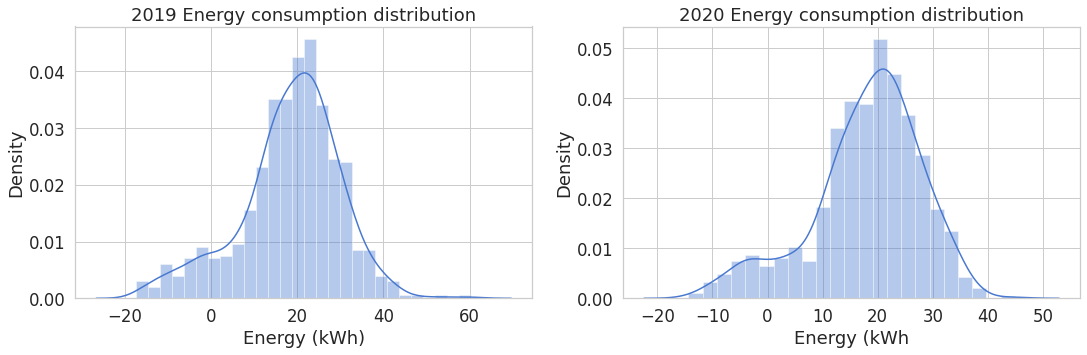

In [10]:
fig, ax = plt.subplots(1,2, figsize=(18,5))
sns.distplot(data_2019["Energy"], kde=True, ax=ax[0])
sns.distplot(data_2020["Energy"], kde=True, ax=ax[1])
ax[0].set_title("2019 Energy consumption distribution")
ax[0].set_xlabel("Energy (kWh)")
ax[1].set_title("2020 Energy consumption distribution")
ax[1].set_xlabel("Energy (kWh")
plt.show()

The distribution plot above shows that energy measurements are normaly distributed and therefore does not contain considerable amount of outliers. There is no need for feature engineering for this parameter.

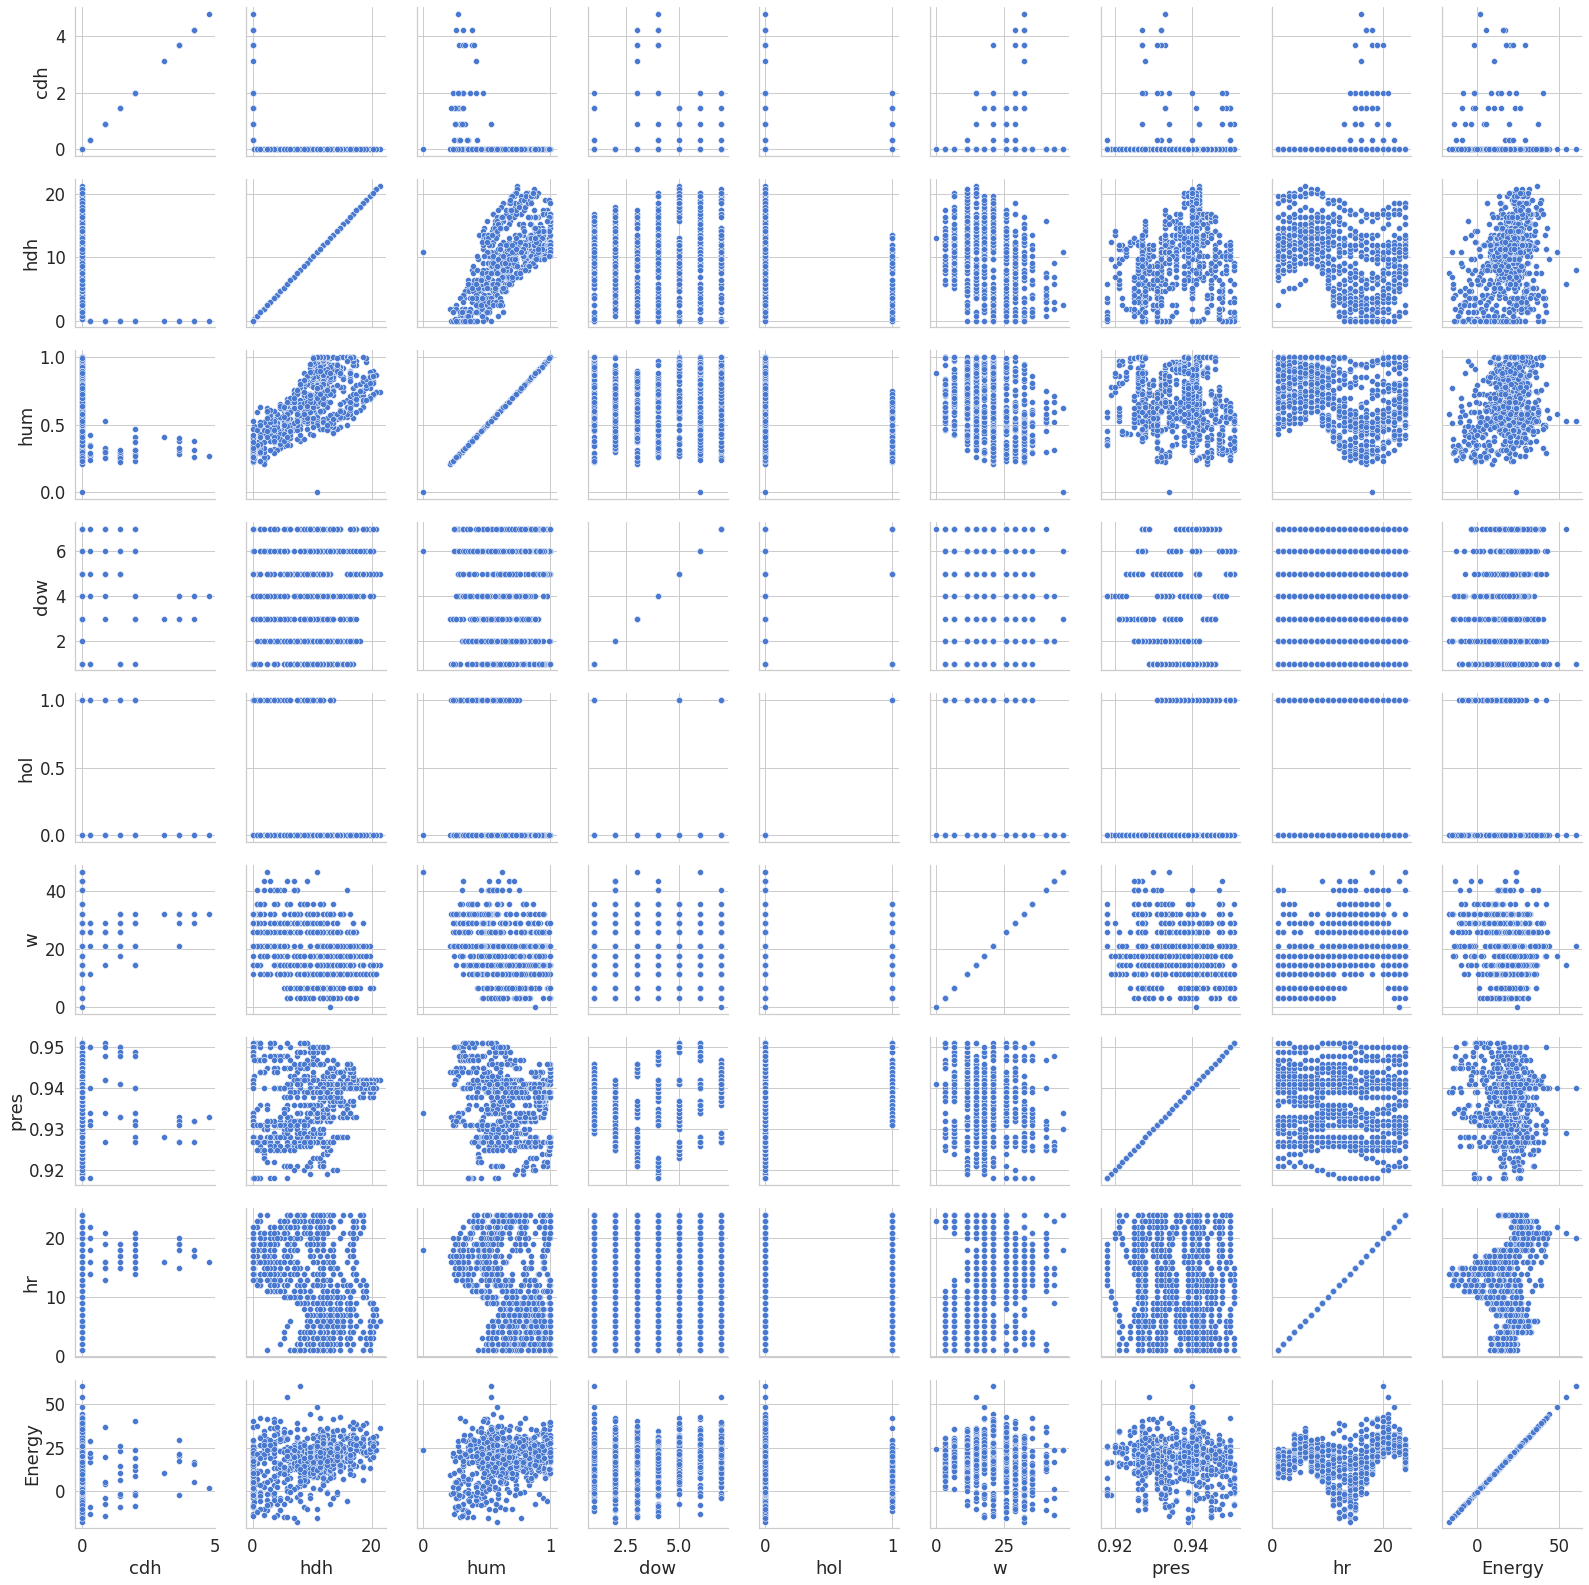

In [11]:
grid = sns.PairGrid(data_2019)
grid.map(sns.scatterplot)

Text(0.5, 0.98, 'Histogram of features')

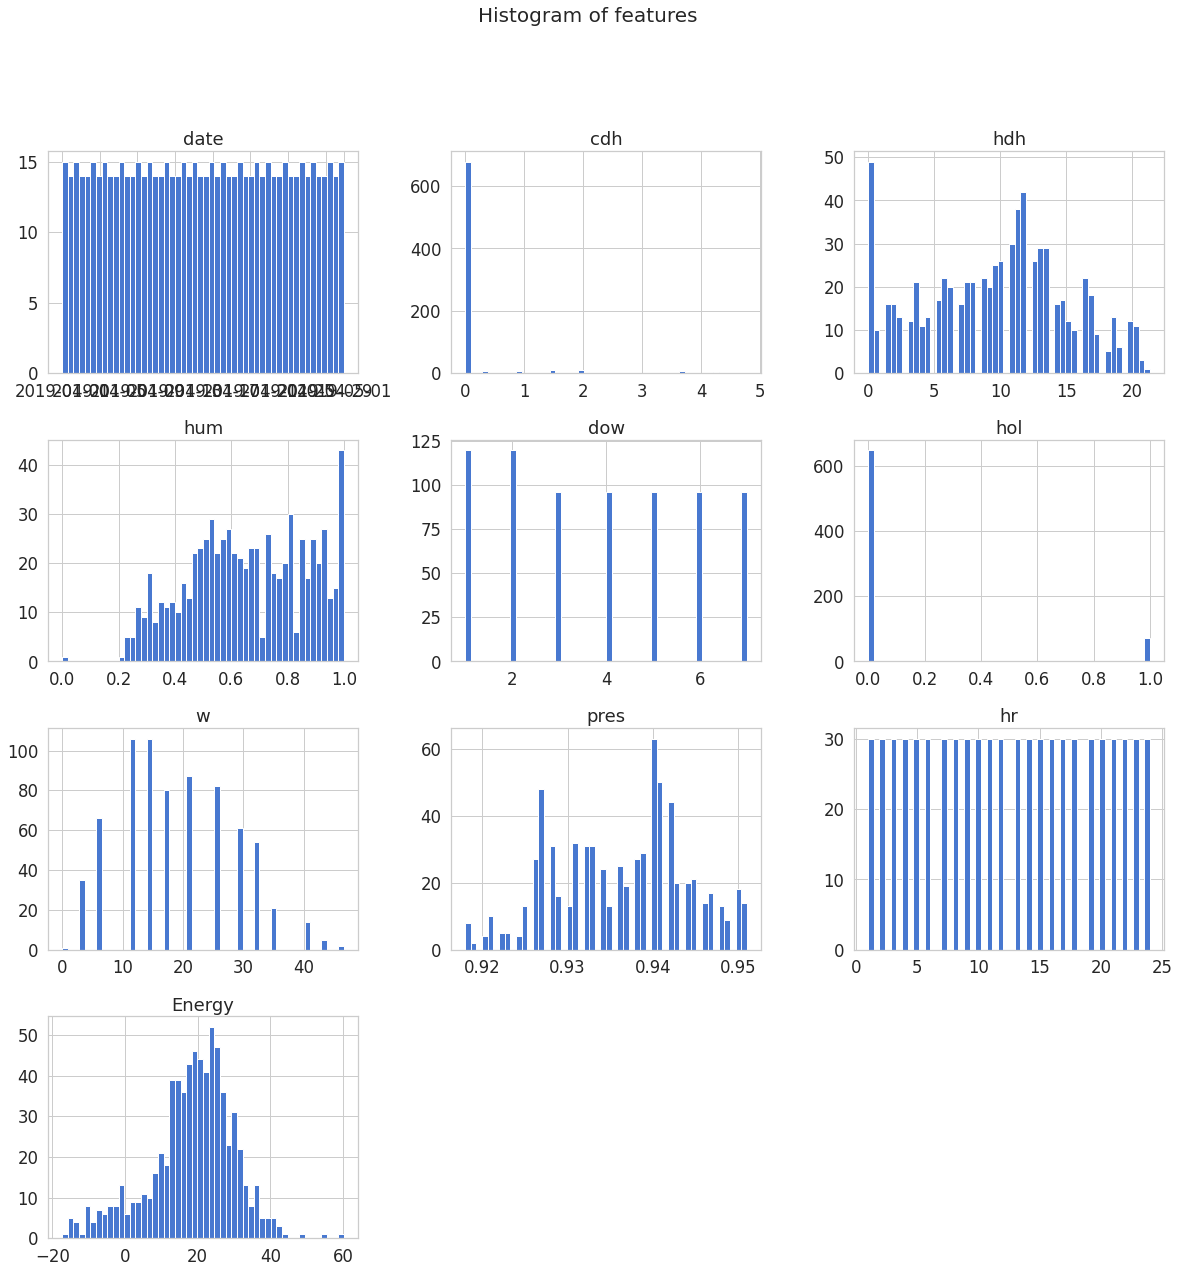

In [12]:
data_2019.hist(bins=50, figsize=(20,20))
plt.suptitle('Histogram of features', fontsize=20)

The distribution above shows that there is no dependency of any feature on the target variable. The cdh, hdh, and hum features are skewed. We will use nlog to normalize them.

Text(0.5, 1.0, 'Correlation Matrix of Features')

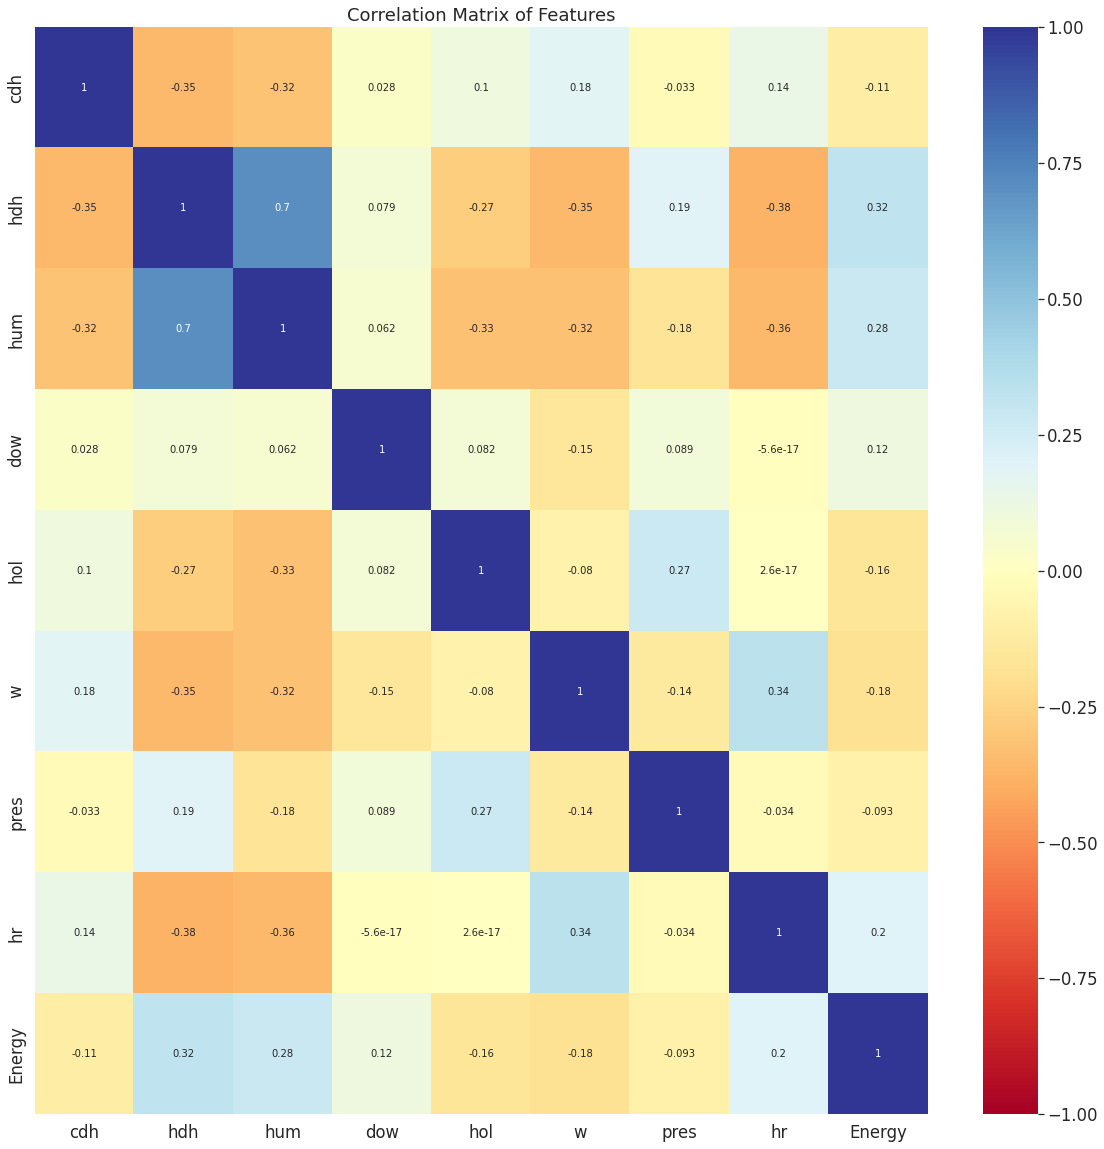

In [14]:
plt.figure(figsize=(20,20))
sns.heatmap(data_2019.corr(), annot=True,
            vmin=-1, vmax=1,cmap='RdYlBu').set_title(
                'Correlation Matrix of Features'
            )

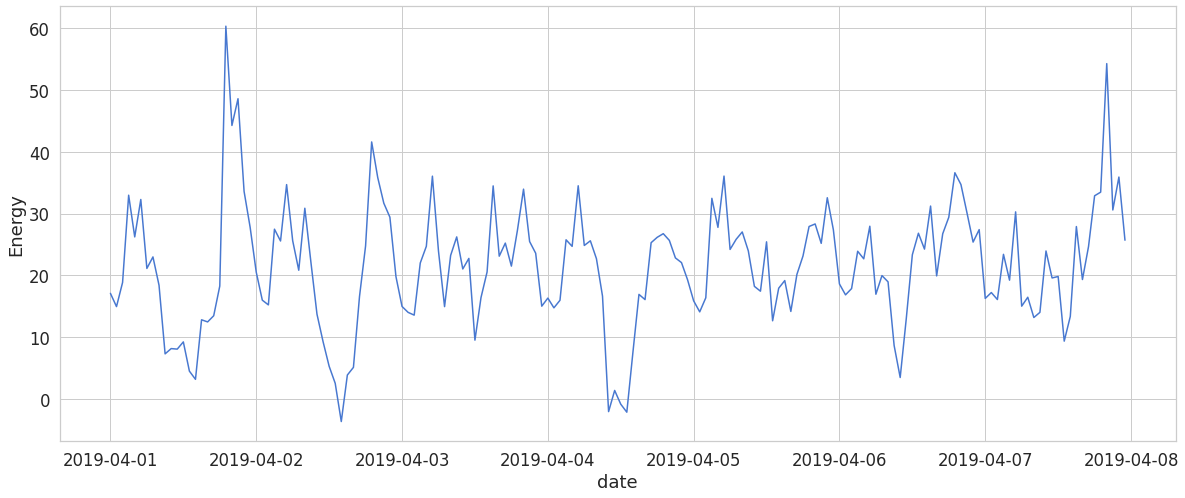

In [15]:
fig = plt.subplots(figsize=(20,8))
wk1 = data_2019.iloc[:168]
sns.lineplot(x=wk1['date'], y='Energy', data=wk1)

The figure above shows that there is seasonality in the data. The weekly trend tends to repeat each day but with different tresholds.

### Preprocessing

There are no categorical features in the dataset.

In [16]:
data_2019['cdh'] = np.log1p(data_2019['cdh'])
data_2019['hdh'] = np.log1p(data_2019['hdh'])
data_2019['hum'] = np.log1p(data_2019['hum'])
data_2020['cdh'] = np.log1p(data_2020['cdh'])
data_2020['hdh'] = np.log1p(data_2020['hdh'])
data_2020['hum'] = np.log1p(data_2020['hum'])

In [17]:
X = data_2019.drop(["Energy", "date"], axis=1)
y = np.array(data_2019["Energy"])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Modeling

We will try XGBoost algorithm first

In [32]:
params = {
    "n_estimators": 500,
    "max_depth": 5,
    "min_samples_split": 5,
    "learning_rate": 0.1,
    "loss": "squared_error",
}

xgb = GradientBoostingRegressor(**params)

xgb.fit(X_train, y_train)

y_pred = xgb.predict(X_test)

Let's try random forest

In [28]:
rfr = RandomForestRegressor(n_estimators=200,
                            criterion="squared_error",
                            max_depth=6
                            )

rfr.fit(X_train, y_train)

y_pred = rfr.predict(X_test)

Let's try Light GBM

In [30]:
gbm = lgb.LGBMRegressor(num_leaves=42,
                        max_depth=4,
                        learning_rate=0.1,
                        n_estimators=1000
                        )

gbm.fit(X_train, y_train, eval_set=[(X_test, y_test)],
        eval_metric="l1",
        callbacks=[lgb.early_stopping(5)])

y_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration_)

[1]	valid_0's l2: 118.128	valid_0's l1: 8.3251
Training until validation scores don't improve for 5 rounds.
[2]	valid_0's l2: 106.831	valid_0's l1: 7.87315
[3]	valid_0's l2: 97.5741	valid_0's l1: 7.47
[4]	valid_0's l2: 90.1419	valid_0's l1: 7.16255
[5]	valid_0's l2: 83.8083	valid_0's l1: 6.86316
[6]	valid_0's l2: 78.6766	valid_0's l1: 6.59852
[7]	valid_0's l2: 73.1496	valid_0's l1: 6.35973
[8]	valid_0's l2: 68.868	valid_0's l1: 6.17052
[9]	valid_0's l2: 65.356	valid_0's l1: 6.01873
[10]	valid_0's l2: 62.0283	valid_0's l1: 5.86105
[11]	valid_0's l2: 59.714	valid_0's l1: 5.73371
[12]	valid_0's l2: 57.2452	valid_0's l1: 5.63167
[13]	valid_0's l2: 55.3712	valid_0's l1: 5.53951
[14]	valid_0's l2: 53.4311	valid_0's l1: 5.46231
[15]	valid_0's l2: 51.6441	valid_0's l1: 5.38402
[16]	valid_0's l2: 49.8737	valid_0's l1: 5.30139
[17]	valid_0's l2: 48.6436	valid_0's l1: 5.22506
[18]	valid_0's l2: 47.454	valid_0's l1: 5.17902
[19]	valid_0's l2: 46.166	valid_0's l1: 5.1046
[20]	valid_0's l2: 45.0409	

In [33]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("The mean squared error: {} \nR2 score: {}".format(mse, r2))

The mean squared error: 27.486576651207425 
R2 score: 0.7852433546284185


The best regression algorithm is the XGBoost using its current parameters. The R-squared score is 0.78.

### Conclusion
The load prediction using weather measurements can be a good tool for estimating energy savings.

However, a lot of data is needed for training the model so that it can produce beter estimations. One way to do this is to increase the granularity of the data set. That is instead of taking hourly measurements, we can start taking minute or 10 seconds measurements.

With XGBoost, we can obtain more accurate estimation of the load consumption during CVR. The next step would be to use a larger data set to build a better model. The new model can be used to estimate energy consumption using new weather data.